In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data',name='gb1')
print(f'training N: {len(data_df):,}')
data_df.head()

training N: 429,674


,input_ct,selected_ct,hamming_dist,training_set,y,dy,x
0,1759616.0,3041819.0,0,True,0.000000,0.001366,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,14663.0,38476.0,1,True,0.602044,0.014001,AYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,13001.0,23023.0,1,True,0.034732,0.015827,CYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,11488.0,18085.0,1,True,-0.135053,0.017212,DYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,9501.0,15629.0,1,True,-0.071659,0.018767,EYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(regression_type='GE',
                     L=len(data_df['x'][0]),
                     alphabet='protein',
                     gpmap_type='additive',                     
                     ge_noise_model_type='Cauchy',
                     ge_heteroskedasticity_order=2)

In [12]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'])

N = 429,674 observations set as training data.
Data shuffled.
Time to set data: 21.0 sec.


In [13]:
# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=2,
                    early_stopping=True,
                    linear_initialization=False,
                    early_stopping_patience=10)

Epoch 1/2
6875/6875 [==============================] - 18s 3ms/step - loss: 10.9770 - val_loss: 7.7444
Epoch 2/2
6875/6875 [==============================] - 16s 2ms/step - loss: 10.9101 - val_loss: 8.1356
Training time: 45.9 seconds


In [6]:
# Save model
model.save('gb1_ge_additive')

Model saved to these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [7]:
print(model.x_stats)

{'N': 429674, 'L': 55, 'C': 20, 'alphabet': array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype='<U1'), 'probability_df':            A         C         D         E         F         G         H  \
0   0.001946  0.001915  0.001897  0.001915  0.001936  0.001960  0.001897   
1   0.001904  0.001897  0.001908  0.001887  0.001908  0.001899  0.001904   
2   0.001864  0.001883  0.001899  0.001894  0.001943  0.001911  0.001853   
3   0.001918  0.001922  0.001948  0.001874  0.001913  0.001894  0.001953   
4   0.001929  0.001906  0.001841  0.001878  0.001922  0.001913  0.001934   
5   0.001920  0.001927  0.001939  0.001899  0.001915  0.001899  0.001939   
6   0.001920  0.001878  0.001960  0.001906  0.001869  0.001904  0.001911   
7   0.001922  0.001922  0.001880  0.001883  0.001925  0.963740  0.001899   
8   0.001932  0.001894  0.001901  0.001894  0.001953  0.001887  0.001936   
9   0.001913  0.001925  0.001974  0.001892  0.001

In [8]:
# Load model
model = mavenn.load('gb1_ge_additive')

Model loaded from these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [9]:
# Load test data
test_df = mavenn.load_example(which='test_data',name='gb1')
N_test = len(test_df)
print(f'test data N: {N_test:,}')

# Subsample indices for easy plotting
ix = np.random.rand(N_test) < .1

# Get x and y
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

test data N: 107,289


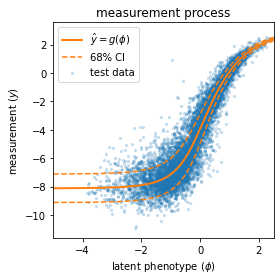

In [10]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

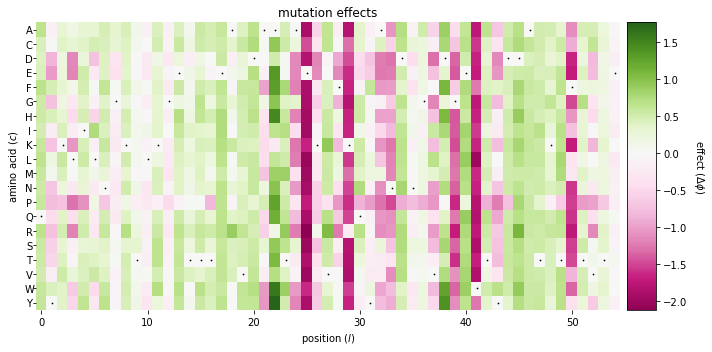

In [11]:
# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
dphi_df = mavenn.get_1pt_effects(func=model.x_to_phi,
                                 wt_seq=gb1_seq,
                                 alphabet='protein')

# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[10, 5])

# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb = mavenn.heatmap(dphi_df,
                        c_col='c_mut',
                        l_col='l',
                        value_col='dphi',
                        seq=gb1_seq,
                        ccenter=0,
                        missing_values=0,
                        cmap='PiYG',
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax.set_title('mutation effects')

# Fix up plot
fig.tight_layout()
plt.show()
